# Ideas

- labels are given only for middle image in sequence: let's try to predict labels for the rest of the sequence by using some kind of simple optical flow predicting (x, y) shift between frames
- there is individual labelers output for each record, labels are calculated as 50% vote of labelers: let's use some Bayesian approach to obtain soft labels for each record (~ GT is 50% vote of labelers, labeler's reliability is intersection of its output and GT or something like that)
- if additional augmentations are needed, copy-pasting positive mix aug could be a good idea

In [1]:
# %matplotlib ipympl

In [2]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn.functional as F
from pathlib import Path
from tqdm import tqdm

import sys
sys.path.insert(0, '/workspace/contrails/lib/unimatch')
from utils.frame_utils import read_gen
from unimatch.unimatch import UniMatch

from src.data.datasets import ContrailsDataset, BANDS

# Single record visualization

In [2]:
BASE_DIR = '/workspace/data/train'
record_id = '1704010292581573769'

In [3]:
data = {}
for band in range(8, 17):
    data[band] = np.load(os.path.join(BASE_DIR, record_id, f'band_{band:02}.npy'))

In [4]:
data[8].min((0, 1)), data[8].max((0, 1))

(array([217.03496, 216.71512, 216.64188, 216.58307, 217.03197, 217.49298,
        217.72519, 216.18779], dtype=float32),
 array([236.81677, 236.72633, 236.79573, 237.0424 , 237.27965, 237.38416,
        237.42242, 237.44275], dtype=float32))

In [5]:
labels = np.load(os.path.join(BASE_DIR, record_id, 'human_pixel_masks.npy'))
labels.shape

(256, 256, 1)

In [6]:
individual_labels = np.load(os.path.join(BASE_DIR, record_id, 'human_individual_masks.npy'))
individual_labels.shape

(256, 256, 1, 4)

### Animation

In [ ]:
plt.close('all')

fig, axes = plt.subplots(3, 3, dpi=90, figsize=(5, 5))
fig.suptitle(f'Record {record_id}')

ims = []
for band, ax in zip(data, axes.flat):
    im = ax.imshow(data[band][:, :, 0], animated=True)
    ax.set_title(f'Band {band:02}')
    ims.append(im)
i = 0

def updatefig(*args):
    global ims, i
    for band, im in zip(data, ims):
        im.set_array(data[band][:, :, i])
    i = (i + 1) % 8
    return ims

# remove axes and spacing
for ax in axes.flat:
    ax.set_axis_off()

fig.subplots_adjust(hspace=0, wspace=0)
fig.tight_layout()

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True, repeat=True)

# writer = animation.ImageMagickFileWriter()
# ani.save('./animation.gif', writer=writer)


### Mean, std, min, max, quantiles

Full, single time index

In [3]:
record_dirs = []
for data_dir in [Path('/workspace/data/train'), Path('/workspace/data/validation')]:
    record_dirs += [path for path in data_dir.iterdir() if path.is_dir()]
dataset = ContrailsDataset(
    record_dirs=record_dirs, 
    band_ids=BANDS,
    mask_type='voting50',
    propagate_mask=False,
    mmap=True,
    transform=None,
)

In [24]:
def calc_stats(dataset):
    # mean, std, min, max across all images
    min_, max_ = float('inf'), float('-inf')
    sums, sums_sq, ns = [], [], []
    for item in tqdm(dataset):
        image = item['image']
        sums.append(image.sum())
        sums_sq.append((image ** 2).sum())
        ns.append(np.prod(image.shape))
        min_ = min(min_, image.min())
        max_ = max(max_, image.max())
    mean = sum(sums) / sum(ns)

    sum_sq = 0
    for sum_, sum_sq_, n in zip(sums, sums_sq, ns):
        sum_sq += (sum_sq_ - 2 * sum_ * mean + mean ** 2 * n)
    std = np.sqrt(sum_sq / sum(ns))

    return mean, std, min_, max_

In [25]:
mean, std, min_, max_ = calc_stats(dataset)
mean, std, min_, max_

100%|██████████| 22385/22385 [16:22<00:00, 22.79it/s]


(260.1077976678496, 21.99711806156345, 178.84055, 336.71628)

In [5]:
def histogram(dataset, min_, max_, bins=256):
    # histogram of pixel values
    hist = np.zeros(bins, dtype=np.uint64)
    for item in tqdm(dataset):
        image = item['image']
        hist += np.histogram(image, bins=bins, range=(min_, max_), density=False)[0].astype(np.uint64)
    bins = np.linspace(min_, max_, bins)
    return hist, bins

In [7]:
min_, max_ = 178.84055, 336.71628
hist, bins = histogram(dataset, min_, max_, bins=256)

100%|██████████| 22385/22385 [19:02<00:00, 19.59it/s]


(array([2.90185500e+06, 9.92071520e+07, 5.70444257e+08, 2.47555910e+09,
        3.13785945e+09, 2.77101581e+09, 2.61239484e+09, 1.49118157e+09,
        4.25049050e+07, 1.41307000e+05]),
 array([178.84055 , 194.628123, 210.415696, 226.203269, 241.990842,
        257.778415, 273.565988, 289.353561, 305.141134, 320.928707,
        336.71628 ]),
 <BarContainer object of 10 artists>)

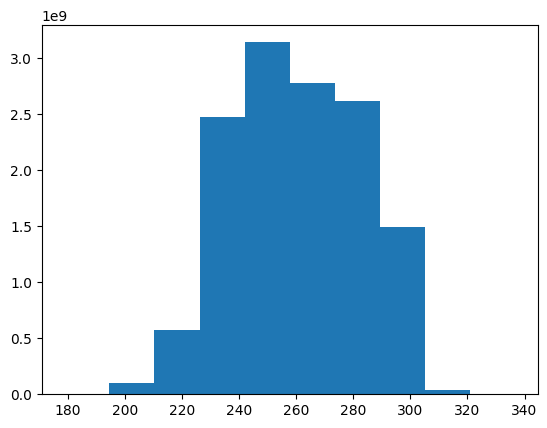

In [8]:
val, weight = zip(*[(k, v) for k,v in zip(bins, hist)])
plt.hist(val, weights=weight)

In [9]:
hist_density = hist / hist.sum()
qs = np.arange(1, 20) / 20
# first occurence of cumulative sum >= q ~ quantile
quantiles = bins[(np.cumsum(hist_density)[:, None] >= qs[None, :]).argmax(axis=0)]
quantiles

array([225.89370875, 232.08491384, 235.7996369 , 238.89523945,
       242.60996251, 245.70556506, 249.42028812, 252.51589067,
       256.23061373, 259.32621627, 263.04093933, 267.3747829 ,
       271.08950596, 274.18510851, 279.13807259, 283.47191616,
       287.18663922, 290.28224176, 293.37784431])

In [10]:
quantiles_dict = {q: q_ for q, q_ in zip(qs, quantiles)}
quantiles_dict

{0.05: 225.89370874509805,
 0.1: 232.08491384313726,
 0.15: 235.79963690196078,
 0.2: 238.8952394509804,
 0.25: 242.60996250980392,
 0.3: 245.70556505882354,
 0.35: 249.42028811764706,
 0.4: 252.51589066666668,
 0.45: 256.23061372549023,
 0.5: 259.3262162745098,
 0.55: 263.0409393333333,
 0.6: 267.37478290196077,
 0.65: 271.0895059607843,
 0.7: 274.1851085098039,
 0.75: 279.1380725882353,
 0.8: 283.47191615686273,
 0.85: 287.1866392156863,
 0.9: 290.2822417647059,
 0.95: 293.3778443137255}

In [11]:
hist_dict = {k: v for k, v in zip(bins, hist)}
hist_dict

{178.84055: 8,
 179.45967050980394: 10,
 180.07879101960785: 21,
 180.69791152941178: 40,
 181.3170320392157: 107,
 181.93615254901962: 222,
 182.55527305882353: 484,
 183.17439356862747: 1106,
 183.79351407843137: 2074,
 184.4126345882353: 3687,
 185.0317550980392: 6214,
 185.65087560784315: 8921,
 186.26999611764705: 13206,
 186.889116627451: 18495,
 187.50823713725492: 26920,
 188.12735764705883: 37452,
 188.74647815686276: 53783,
 189.36559866666667: 73714,
 189.9847191764706: 100841,
 190.6038396862745: 136533,
 191.22296019607845: 184309,
 191.84208070588235: 247158,
 192.4612012156863: 326065,
 193.0803217254902: 426149,
 193.69944223529413: 552589,
 194.31856274509803: 681747,
 194.93768325490197: 824624,
 195.55680376470588: 984588,
 196.1759242745098: 1152364,
 196.79504478431375: 1324257,
 197.41416529411765: 1537067,
 198.0332858039216: 1742189,
 198.6524063137255: 1982076,
 199.27152682352943: 2223597,
 199.89064733333333: 2509276,
 200.50976784313727: 2771390,
 201.128888

Stats [from histogram](https://stackoverflow.com/questions/50786699/how-to-calculate-the-standard-deviation-from-a-histogram-python-matplotlib) as self-check

In [15]:
mids = 0.5*(bins[1:] + bins[:-1])
mean = np.average(mids, weights=hist[:-1])
var = np.average((mids - mean)**2, weights=hist[:-1])
std = np.sqrt(var)
mean, std

(260.4264655384578, 22.084094376561833)

### Labels vs frame alignment

No alignment

In [ ]:
plt.close('all')

fig, axes = plt.subplots(2, 4, dpi=90, figsize=(8, 4))
fig.suptitle(f'Record {record_id}')

for frame_index, ax in zip(range(8), axes.flat):
    ax.imshow(data[8][:, :, frame_index])
    ax.imshow(labels, alpha=0.5, cmap='gray')
    ax.set_title(f'Frame {frame_index}')

# remove axes and spacing
for ax in axes.flat:
    ax.set_axis_off()

fig.subplots_adjust(hspace=0, wspace=0)
fig.tight_layout()

Optical flow

In [ ]:
 
prev_gray = data[8][:, :, 0]

# Creates an image filled with zero
# intensities with the same dimensions 
# as the frame
mask = np.zeros((*data[8].shape[:2], 3), dtype=np.uint8)

# Sets image saturation to maximum
mask[..., 1] = 255

for frame_index in range(1, data[8].shape[2]):
    frame = data[8][:, :, frame_index]

    # Opens a new window and displays the input
    # frame
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    ax = axes[0]
    ax.imshow(frame, cmap='gray')
      
    # Converts each frame to grayscale - we previously 
    # only converted the first frame to grayscale
    gray = frame
      
    # Calculates dense optical flow by Farneback method
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, 
                                       None,
                                       0.5, 3, 15, 3, 5, 1.2, 0)
      
    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
      
    # Sets image hue according to the optical flow 
    # direction
    mask[..., 0] = angle * 180 / np.pi / 2
      
    # Sets image value according to the optical flow
    # magnitude (normalized)
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
      
    # Converts HSV to RGB (BGR) color representation
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
      
    # Opens a new window and displays the output frame
    ax = axes[1]
    ax.imshow(rgb, cmap='gray')
      
    # Updates previous frame
    prev_gray = gray

Convolution

In [ ]:
from scipy.signal import convolve2d

In [ ]:
labels[:, :, 0] > 0

In [ ]:
mask = labels[:, :, 0] > 0
trails = np.zeros_like(data[8][:, :, 4])
trails[mask] = data[8][:, :, 4][mask]

conv = convolve2d(data[8][:, :, 0], trails, mode='same')
print(np.unravel_index(conv.argmax(), conv.shape))
conv = convolve2d(trails, data[8][:, :,-1], mode='same')
print(np.unravel_index(conv.argmax(), conv.shape))

In [ ]:
plt.imshow(mask, cmap='gray')

In [ ]:
plt.close('all')

In [ ]:
data[8][:, :, 4].min()

In [ ]:
trails.min(), trails.max()

In [ ]:
plt.figure()
plt.imshow(trails, vmin=217.03197, vmax=235.95107)
plt.show()

In [ ]:
prev_frame = data[8][:, :, 0]
conv = convolve2d(data[8][:, :, 0], data[8][:, :, 4], mode='same')
print(np.unravel_index(conv.argmax(), conv.shape))
conv = convolve2d(data[8][:, :, 4], data[8][:, :,-1], mode='same')
print(np.unravel_index(conv.argmax(), conv.shape))
conv = convolve2d(data[8][:, :, 0], data[8][:, :,-1], mode='same')
print(np.unravel_index(conv.argmax(), conv.shape))

Unimatch

In [271]:
feature_channels = 128
num_scales = 2
upsample_factor = 4
num_head = 1
ffn_dim_expansion = 4
num_transformer_layers = 6
attn_splits_list = [2, 8]
corr_radius_list = [-1, 4]
prop_radius_list = [-1, 1]
reg_refine = True
num_reg_refine = 6
task = 'flow'
attn_type = 'swin'
pred_bidir_flow = False
padding_factor = 32
device = 'cuda'
fixed_inference_size = None
resume = '/workspace/contrails/lib/unimatch/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth'

In [272]:
model = UniMatch(
    feature_channels=feature_channels,
    num_scales=num_scales,
    upsample_factor=upsample_factor,
    num_head=num_head,
    ffn_dim_expansion=ffn_dim_expansion,
    num_transformer_layers=num_transformer_layers,
    reg_refine=reg_refine,
    task=task
).to(device)
checkpoint = torch.load(resume, map_location=device)
model.load_state_dict(checkpoint['model'], strict=True)

<All keys matched successfully>

In [273]:
# https://www.kaggle.com/code/inversion/visualizing-contrails
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)
N_TIMES_BEFORE = 4

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

def get_color_images(data, type_='false', mult=1.0):
    band11 = data[11]
    band14 = data[14]
    band15 = data[15]
    if type_ == 'false':
        r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
        g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
        b = normalize_range(band14, _T11_BOUNDS)
        colored = np.clip(np.stack([r, g, b], axis=2), 0, 1) * mult
    elif type_ == 'minmax3':
        r = (band11 - band11.min()) / (band11.max() - band11.min())
        g = (band14 - band14.min()) / (band14.max() - band14.min())
        b = (band15 - band15.min()) / (band15.max() - band15.min())
        colored = np.stack([r, g, b], axis=2) * mult
    elif type_ == 'minmax1':
        r = g = b = (band11 - band11.min()) / (band11.max() - band11.min())
        colored = np.stack([r, g, b], axis=2) * mult
    return colored

In [274]:
color_images = get_color_images(data, type_='false', mult=255)

In [275]:
color_images.shape

(256, 256, 3, 8)

In [276]:
color_images

array([[[[  0.        ,   0.        ,   0.        , ...,  50.029068  ,
           58.48484   ,  25.939293  ],
         [205.82565   , 216.97983   , 169.52097   , ...,  93.70112   ,
           78.20892   ,  62.1093    ],
         [208.01472   , 214.77364   , 196.40906   , ...,  10.728695  ,
            0.        ,  53.867336  ]],

        [[  0.        ,   0.        ,   0.        , ...,  37.4255    ,
           68.723335  ,  34.417763  ],
         [198.95157   , 215.83588   , 176.9986    , ...,  86.27322   ,
          106.316574  ,  62.976128  ],
         [203.36914   , 214.63927   , 200.75569   , ...,  21.43171   ,
            0.        ,  35.368916  ]],

        [[  0.        ,   0.        ,   0.        , ...,  23.228569  ,
           64.326515  ,  54.244957  ],
         [190.1683    , 213.8584    , 194.58328   , ...,  68.72528   ,
          120.63413   ,  67.187904  ],
         [194.32362   , 213.20401   , 209.09526   , ...,  31.006596  ,
            0.        ,  18.281822  ]],

    

In [277]:
color_images.min(), color_images.max()

(0.0, 255.0)

In [325]:
data[8].shape

(256, 256, 8)

In [533]:
from typing import Dict
from scipy.ndimage import geometric_transform


@torch.no_grad()
def calculate_flow(image1, image2, pred_bwd_flow=False):
    transpose_img = False

    image1 = torch.from_numpy(image1).float().permute(2, 0, 1).unsqueeze(0).to(device)
    image2 = torch.from_numpy(image2).float().permute(2, 0, 1).unsqueeze(0).to(device)

    # the model is trained with size: width > height
    if image1.size(-2) > image1.size(-1):
        image1 = torch.transpose(image1, -2, -1)
        image2 = torch.transpose(image2, -2, -1)
        transpose_img = True

    nearest_size = [int(np.ceil(image1.size(-2) / padding_factor)) * padding_factor,
                    int(np.ceil(image1.size(-1) / padding_factor)) * padding_factor]

    # resize to nearest size or specified size
    inference_size = nearest_size if fixed_inference_size is None else fixed_inference_size

    assert isinstance(inference_size, list) or isinstance(inference_size, tuple)
    ori_size = image1.shape[-2:]

    # resize before inference
    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        image1 = F.interpolate(image1, size=inference_size, mode='bilinear',
                                align_corners=True)
        image2 = F.interpolate(image2, size=inference_size, mode='bilinear',
                                align_corners=True)
    
    if pred_bwd_flow:
        image1, image2 = image2, image1

    results_dict = model(
        image1, 
        image2,
        attn_type=attn_type,
        attn_splits_list=attn_splits_list,
        corr_radius_list=corr_radius_list,
        prop_radius_list=prop_radius_list,
        num_reg_refine=num_reg_refine,
        task='flow',
        pred_bidir_flow=pred_bidir_flow,
    )
    flow_pr = results_dict['flow_preds'][-1]  # [B, 2, H, W]

    # resize back
    if inference_size[0] != ori_size[0] or inference_size[1] != ori_size[1]:
        flow_pr = F.interpolate(flow_pr, size=ori_size, mode='bilinear',
                                align_corners=True)
        flow_pr[:, 0] = flow_pr[:, 0] * ori_size[-1] / inference_size[-1]
        flow_pr[:, 1] = flow_pr[:, 1] * ori_size[-2] / inference_size[-2]

    if transpose_img:
        flow_pr = torch.transpose(flow_pr, -2, -1)

    flow = flow_pr[0].permute(1, 2, 0).cpu().numpy()  # [H, W, 2]

    return flow


def get_flow_images_cum(data, labels_time_index, wrt='next', color_type='false', mult=1.0):
    color_images = get_color_images(data, type_=color_type, mult=mult)

    if wrt == 'next':
        flow_images = []
        for i in range(1, color_images.shape[-1]):
            flow = calculate_flow(
                color_images[..., i - 1], 
                color_images[..., i],
                pred_bwd_flow=i < labels_time_index
            )
            flow_images.append(flow)
        
        flow_images = np.stack(flow_images, axis=0)

        # Get cumulative flow images forward and back 
        # w.r.t. labels_time_index
        #
        # Example:
        # 0 1 2 3 4 5 6 7 -- frame indices
        #         ^ labels_time_index
        #  0 1 2 3 4 5 6 -- flow image indices
        # 0 1 2 3 -- flow images back
        # 4 5 6 -- flow images forward
        # 0 1 2 3 x 4 5 6 -- flow images total
        flow_images_cum_back = np.cumsum(flow_images[:labels_time_index][::-1], axis=0)[::-1]
        flow_images_cum_current = np.zeros_like(flow_images_cum_back[0])[None, ...]
        flow_images_cum_forward = np.cumsum(flow_images[labels_time_index:], axis=0)
        flow_images_cum = np.concatenate(
            (
                flow_images_cum_back, 
                flow_images_cum_current, 
                flow_images_cum_forward
            ), 
            axis=0
        )
    elif wrt == 'labeled':
        flow_images_cum = []
        for i in range(color_images.shape[-1]):
            if i == labels_time_index:
                flow = np.zeros((*color_images.shape[:2], 2))
            else:
                flow = calculate_flow(
                    color_images[..., i - 1], 
                    color_images[..., i],
                    pred_bwd_flow=i < labels_time_index
                )
            flow_images_cum.append(flow)
        flow_images_cum = np.stack(flow_images_cum, axis=0)
    else:
        raise ValueError(f'wrt must be either "next" or "labeled", got {wrt}')
    
    return flow_images_cum


def pseudolabel_by_flows(
    data: Dict[int, np.ndarray], 
    labels: np.ndarray, 
    labels_time_index: int = N_TIMES_BEFORE,
):
    """Generate pseudolabels for each frame except labels_time_index.
    data: dict of band data, where each band data is of shape (H, W, T)
    """
    # Get cumulative flow images
    flow_images = get_flow_images_cum(
        data, 
        labels_time_index, 
        wrt='next',
        color_type='minmax3', 
        mult=255
    )

    # Get pseudolabels for each frame except labels_time_index
    pseudolabels = []
    for i in range(flow_images.shape[0]):
        if i == labels_time_index:
            pseudolabels.append(labels)
        else:
            # TODO: see if C extension is needed to speed up
            # def mapping(coords):
            #     h, w = coords
            #     return (h + flow_images_cum[i, h, w, 0], h + flow_images_cum[i, h, w, 1])
                
            def mapping(coords):
                x, y = coords
                return (x + flow_images[i, y, x, 0], y + flow_images[i, y, x, 1])
            
            labels_mapped = geometric_transform(
                labels[..., 0], 
                mapping, 
                order=2,
                output_shape=labels.shape[:2],
            )[..., None]
            pseudolabels.append(labels_mapped)
        
    return np.concatenate(pseudolabels, axis=-1), flow_images

In [534]:
pseudolabels, flow_images = pseudolabel_by_flows(data, labels, labels_time_index=N_TIMES_BEFORE)

In [535]:
pseudolabels.shape, flow_images.shape

((256, 256, 8), (8, 256, 256, 2))

In [536]:
flow_images.min(), flow_images.max()

(-32.240143, 31.55515)

In [537]:
color_images.min(), color_images.max()

(0.0, 255.0)

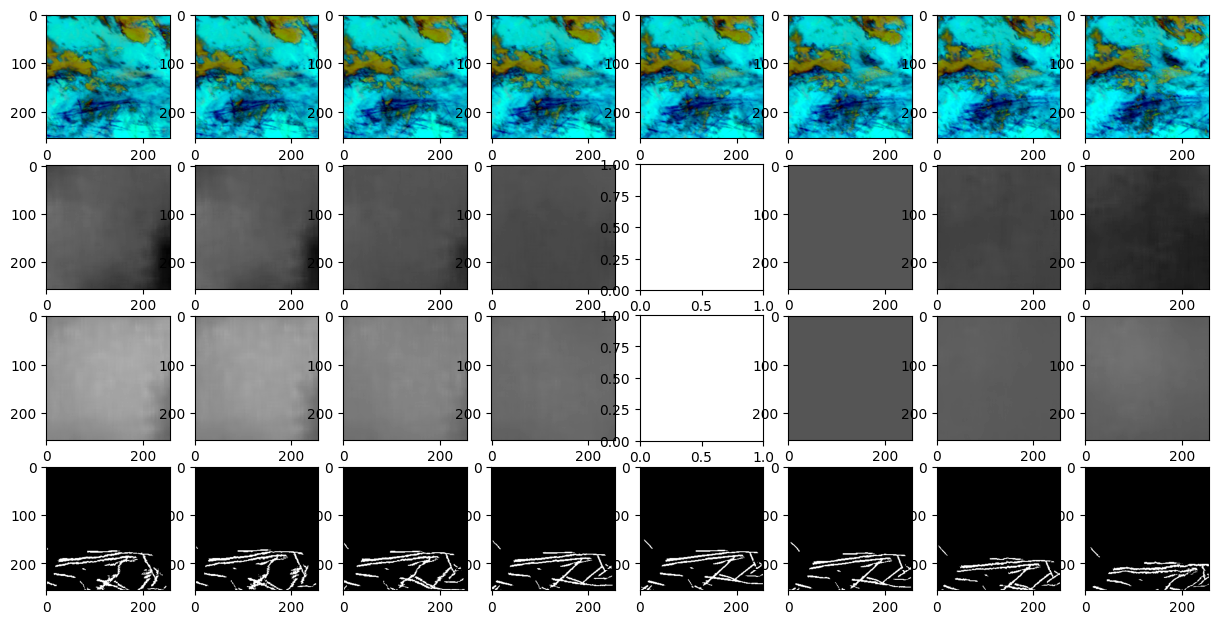

In [538]:
fig, axes = plt.subplots(4, 8, figsize=(15, 7.5))

for i in range(axes.shape[1]):
    axes[0, i].imshow(color_images[..., i].astype(np.uint8))
    if i != N_TIMES_BEFORE:
        axes[1, i].imshow(flow_images[i - (i > N_TIMES_BEFORE), ..., 0], cmap='gray', vmin=-30, vmax=60)
        axes[2, i].imshow(flow_images[i - (i > N_TIMES_BEFORE), ..., 1], cmap='gray', vmin=-30, vmax=60)
    axes[3, i].imshow(pseudolabels[..., i], cmap='gray')

In [311]:
image1.shape

torch.Size([1, 3, 256, 256])

In [312]:
image1_mapped = geometric_transform(
    color_images[..., 0, 0],
    mapping,
    order=1,
    output_shape=image1.shape[-2:],
)
labels_mapped = geometric_transform(
    labels[:, :, 0], 
    mapping, 
    order=1,
    output_shape=labels.shape[:2],
)

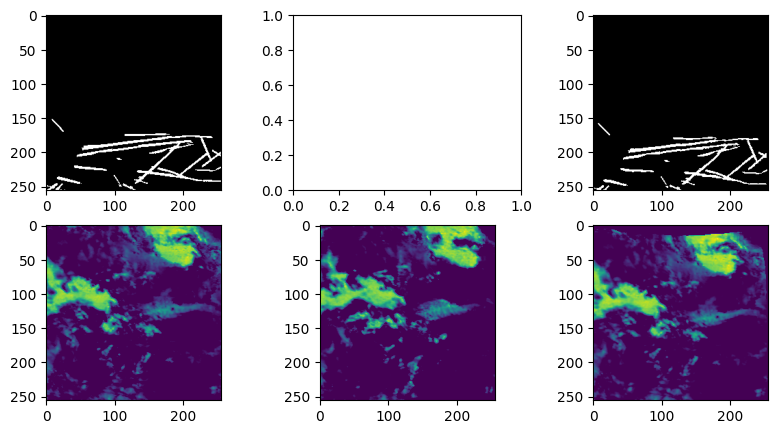

In [313]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
ax = axes[0, 0]
ax.imshow(labels[:, :, 0], cmap='gray')
ax = axes[0, 2]
ax.imshow(labels_mapped, cmap='gray')
ax = axes[1, 0]
ax.imshow(color_images[..., 0, 0])
ax = axes[1, 1]
ax.imshow(color_images[..., 0, 4])
ax = axes[1, 2]
ax.imshow(image1_mapped)

In [228]:
import imageio.v3 as iio
im = iio.imread('/workspace/contrails/lib/unimatch/output/contrails/00000_flow.png')

In [74]:
im

array([[[255, 152, 229],
        [255, 151, 229],
        [255, 151, 228],
        ...,
        [255, 208, 206],
        [255, 208, 206],
        [255, 208, 206]],

       [[255, 152, 229],
        [255, 152, 229],
        [255, 151, 229],
        ...,
        [255, 208, 206],
        [255, 209, 206],
        [255, 209, 206]],

       [[255, 152, 229],
        [255, 151, 228],
        [255, 151, 228],
        ...,
        [255, 208, 206],
        [255, 208, 206],
        [255, 209, 206]],

       ...,

       [[255, 124, 225],
        [255, 122, 223],
        [255, 120, 221],
        ...,
        [255,  68, 115],
        [255,  68, 115],
        [255,  68, 114]],

       [[255, 124, 226],
        [255, 122, 223],
        [255, 120, 221],
        ...,
        [255,  68, 114],
        [255,  68, 114],
        [255,  68, 114]],

       [[255, 125, 227],
        [255, 122, 224],
        [255, 120, 222],
        ...,
        [255,  68, 114],
        [255,  68, 114],
        [255,  68, 113]]